# Import packages and libraries

In [1]:
import os
import glob
import random
from tqdm import tqdm
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

import tensorflow as tf

from tensorflow.keras import layers, models


In [2]:
image_size = 256


In [3]:
with open('deep-globe-sat-img-train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('deep-globe-mask-train.pkl', 'rb') as f:
    y_train = pickle.load(f)
    

In [4]:
X_train = np.array(X_train)
y_train = np.array(y_train)


In [5]:
X_train.shape, y_train.shape


((6226, 256, 256, 3), (6226, 256, 256))

In [6]:
def display_img_mask(index):
    
    fig, ax = plt.subplots(1,2, figsize=(8,5))
    
    ax[0].imshow(X_train[index])
    ax[0].set_title('Satellite Image')
    
    ax[1].imshow(y_train[index], cmap='Greys')
    ax[1].set_title('Road Map')
    

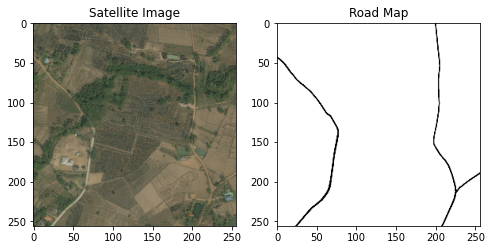

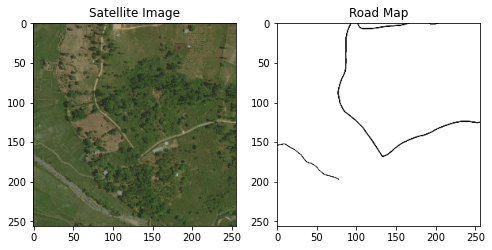

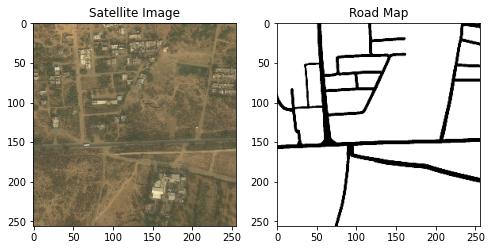

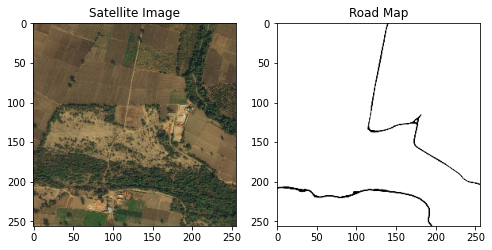

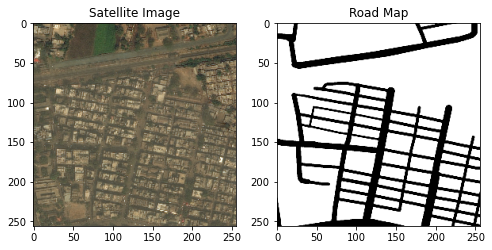

In [7]:
for i in list(np.random.choice(range(len(X_train)), size=5)):
    display_img_mask(i)
    

In [8]:
def Conv2DBlock(inputs, num_filters, kernel_size, doBatchNorm = True):
    x = layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                      kernel_initializer='he_normal', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                      kernel_initializer='he_normal', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x


In [9]:
def get_unet_model(inputs, num_filters, kernel_size=3):
    # encoder
    c1 = Conv2DBlock(inputs, num_filters*1, kernel_size)
    p1 = layers.MaxPooling2D((2,2))(c1)
    
    c2 = Conv2DBlock(p1, num_filters*2, kernel_size)
    p2 = layers.MaxPooling2D((2,2))(c2)
    
    c3 = Conv2DBlock(p2, num_filters*4, kernel_size)
    p3 = layers.MaxPooling2D((2,2))(c3)
    
    c4 = Conv2DBlock(p3, num_filters*8, kernel_size)
    p4 = layers.MaxPooling2D((2,2))(c4)
    
    c5 = Conv2DBlock(p4, num_filters*16, kernel_size)
    
    # decoder
    u6 = layers.Conv2DTranspose(num_filters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = Conv2DBlock(u6, num_filters*8, kernel_size)
    
    u7 = layers.Conv2DTranspose(num_filters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = Conv2DBlock(u7, num_filters*4, kernel_size)
    
    u8 = layers.Conv2DTranspose(num_filters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = Conv2DBlock(u8, num_filters*2, kernel_size)
    
    u9 = layers.Conv2DTranspose(num_filters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = Conv2DBlock(u9, num_filters*1, kernel_size)
    
    # output layer
    output = layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    
    model = models.Model(inputs = [inputs], outputs = [output])
    
    return model


In [10]:
num_filters = 16
kernel_size = 3

tf.keras.backend.clear_session()

inputs = layers.Input((image_size, image_size, 3))

unet = get_unet_model(inputs, num_filters, kernel_size)

unet.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'] )


In [11]:
unet.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

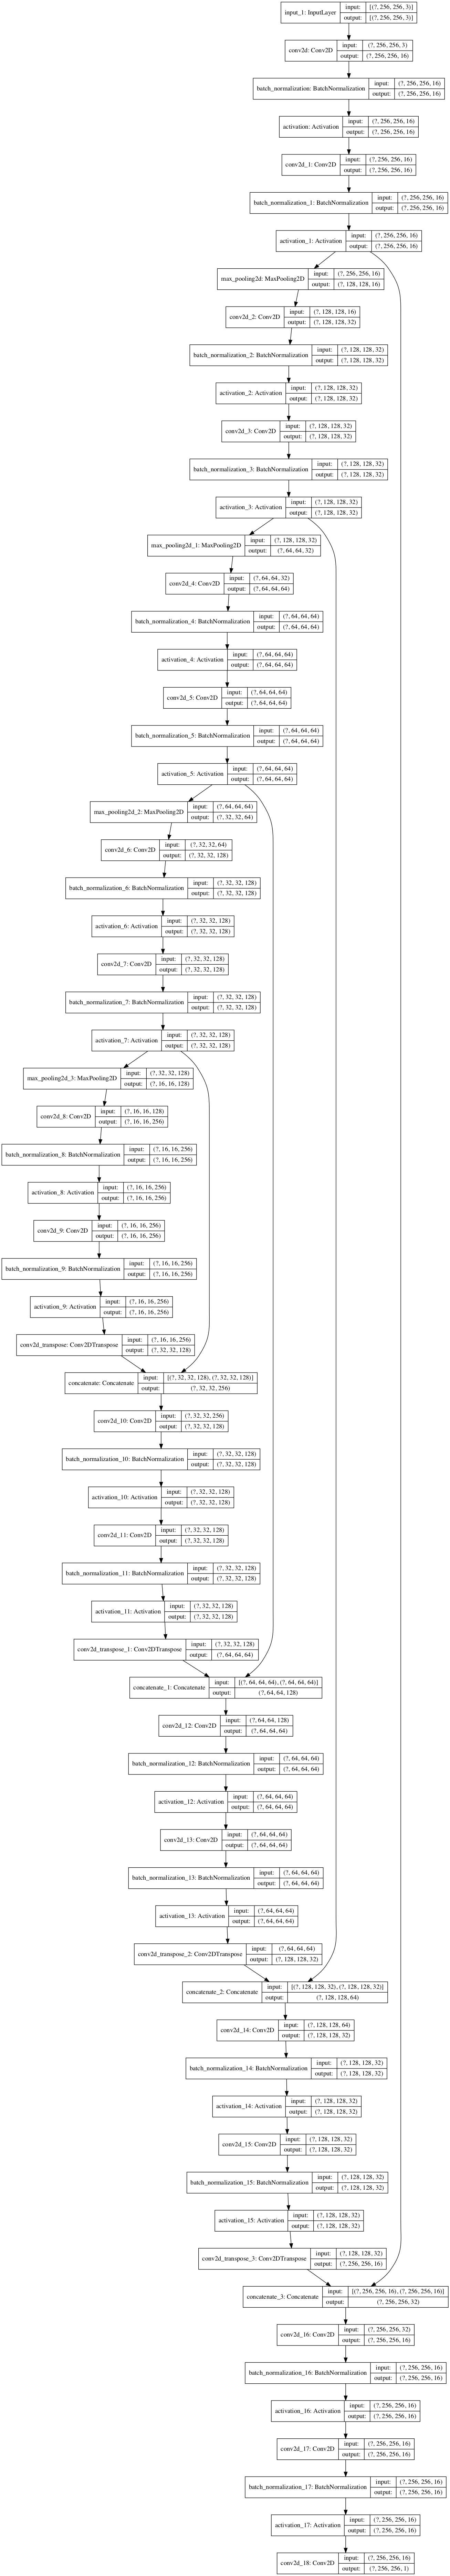

In [12]:
tf.keras.utils.plot_model(unet, to_file='unet_base_model_architecture.png', show_shapes=True, show_layer_names=True)


In [13]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=8, verbose=1, 
                                           restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, 
                                               verbose=1),
             tf.keras.callbacks.ModelCheckpoint('satellite_segmentation_base_model.h5', 
                                             save_best_only=True, save_freq='epoch')]

epochs = 5
history = unet.fit(X_train, y_train,
                       epochs=epochs, batch_size=64,
                       validation_split=0.25, callbacks=callbacks,
                       verbose=1)


Epoch 1/5
73/73 [==============================] - 1477s 20s/step - loss: 0.2956 - accuracy: 0.9350 - val_loss: 4.9406 - val_accuracy: 0.6542 - lr: 0.0010
Epoch 2/5
73/73 [==============================] - 1754s 24s/step - loss: 0.1822 - accuracy: 0.9533 - val_loss: 0.6336 - val_accuracy: 0.7876 - lr: 0.0010
Epoch 3/5
73/73 [==============================] - 2480s 34s/step - loss: 0.1515 - accuracy: 0.9536 - val_loss: 0.1484 - val_accuracy: 0.9534 - lr: 0.0010
Epoch 4/5
73/73 [==============================] - 3024s 41s/step - loss: 0.1289 - accuracy: 0.9559 - val_loss: 0.1402 - val_accuracy: 0.9534 - lr: 0.0010
Epoch 5/5
73/73 [==============================] - 2413s 33s/step - loss: 0.1139 - accuracy: 0.9591 - val_loss: 0.1509 - val_accuracy: 0.9539 - lr: 0.0010


In [14]:
def display_img_mask_pred(index, save_fig=False):
    
    fig, ax = plt.subplots(1,3, figsize=(10,4))
    
    ax[0].imshow(X_train[index])
    ax[0].set_title('Satellite Image')
    
    ax[1].imshow(y_train[index], cmap='Greys')
    ax[1].set_title('Road Map')
    
    predict_data = unet.predict(X_train[index].reshape(-1, 256, 256, 3))[0]
    
    ax[2].imshow(predict_data[:, :, 0], cmap='Greys')
    ax[2].set_title('Predicted Road Map')
    
    plt.tight_layout()
    
    if save_fig:
        fig.savefig(f'figures/predicted_road_map_base_model_{index}.png', dpi=200)
    

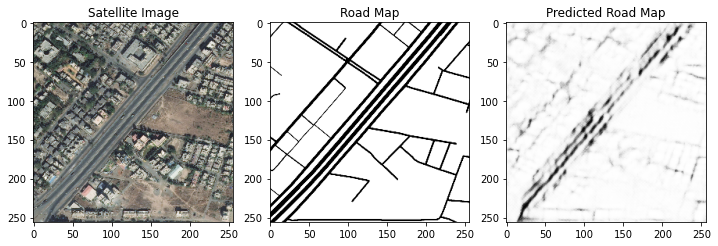

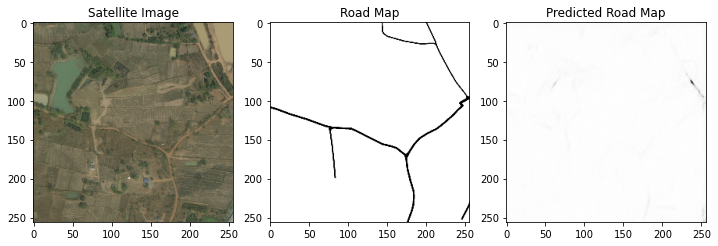

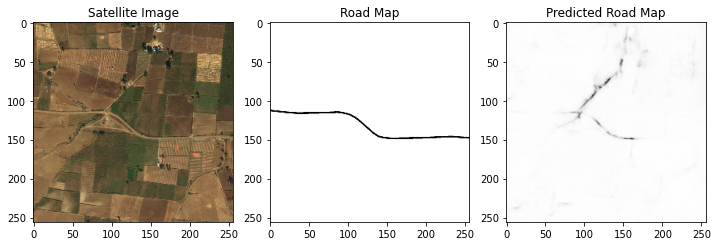

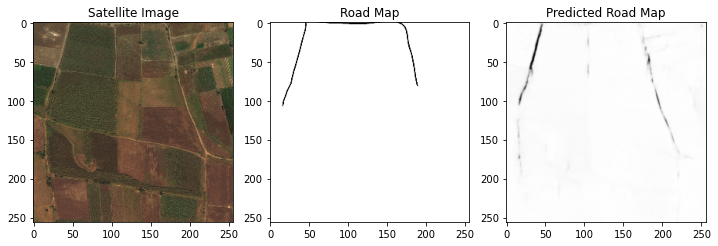

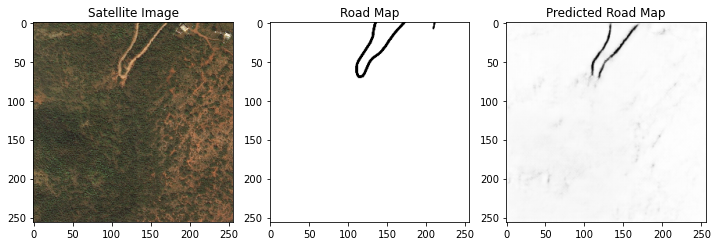

In [15]:
for i in list(np.random.choice(range(len(X_train)), size=5)):
    display_img_mask_pred(i)
    

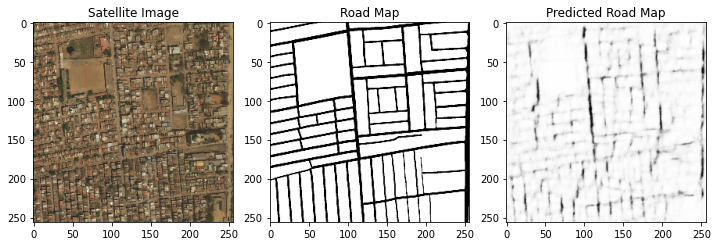

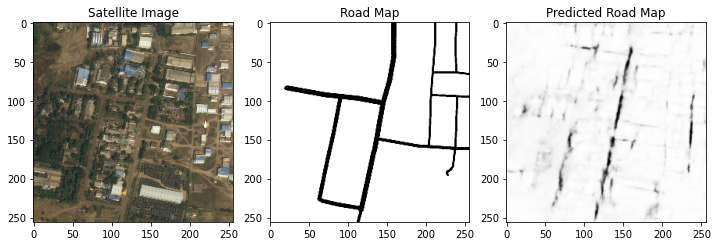

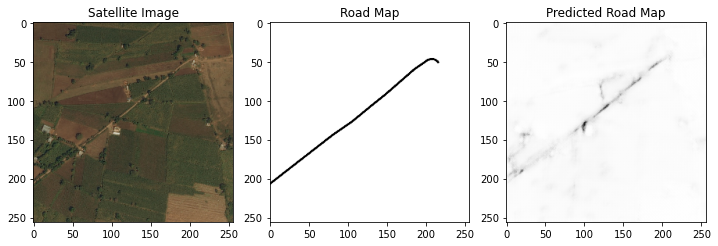

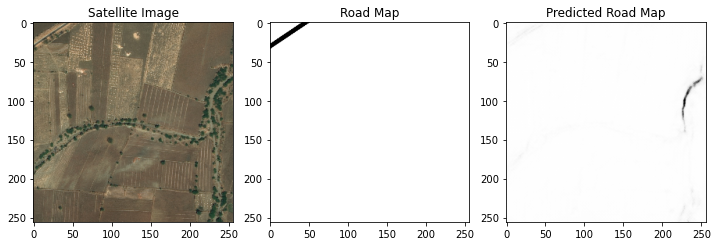

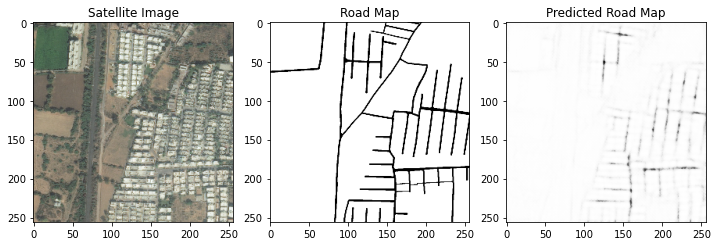

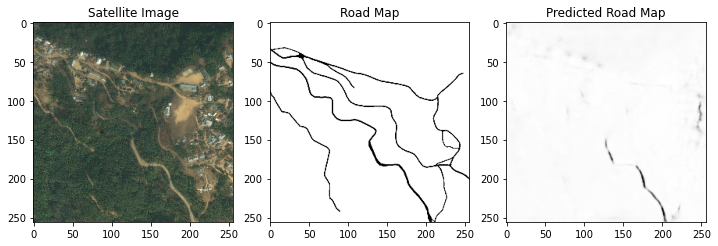

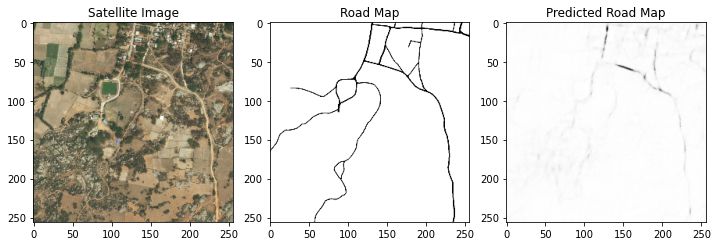

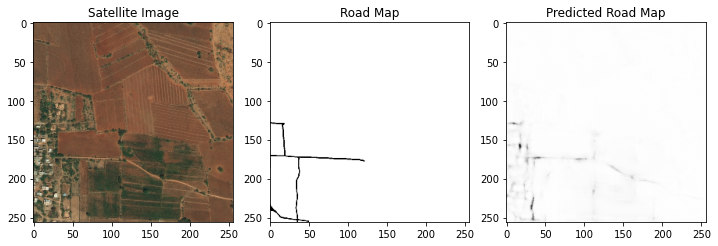

In [16]:
follow_index = [2272, 3492, 5252, 5540, 2896, 6138, 5161, 758]
for i in follow_index:
    display_img_mask_pred(i, save_fig=True)
